# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,Cavity,Bgd)- Testing Travastin and Bevacizumanb Data

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory


In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


## Setup transforms for training and validation

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=200,
            b_min=0.0,
            b_max=1.0,
            clip=False,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200, b_min=0.0, b_max=1.0, clip=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR_MR03.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                  | 0/9 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.11it/s]


In [6]:
print(data_dir)

/home/adminbthomas/Downloads/data/013123_MR/


## Check data shape and visualize

image shape: torch.Size([1, 250, 176, 49]), label shape: torch.Size([1, 250, 176, 49])


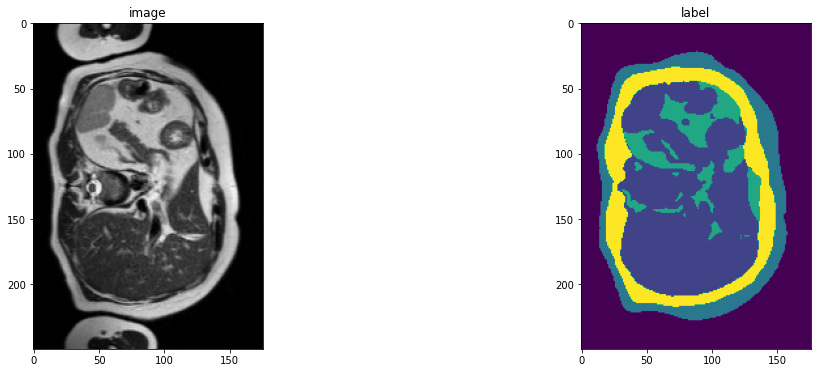

In [7]:
slice_map = {
    "A002_v3_T2W.nii.gz": 10,
    "A002_v3_T2W.nii.gz": 25,
    "A002_v3_T2W.nii.gz": 40
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [8]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1")

model = UNETR(
    in_channels=1,
    out_channels=6,
    img_size=(96, 96, 48),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 48), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR03_May23small.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 70000
eval_num = 500
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR03_May23small.pth")))

Training (500 / 70000 Steps) (loss=1.32773):  67%|█████████████████████████████████████████▎                    | 6/9 [00:07<00:05,  1.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5431406696637472 Current Avg. Dice: 0.5431406696637472


Training (1000 / 70000 Steps) (loss=1.42278):  22%|█████████████▌                                               | 2/9 [00:05<00:22,  3.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6201528708140055 Current Avg. Dice: 0.6201528708140055


Training (1500 / 70000 Steps) (loss=1.10592):  78%|███████████████████████████████████████████████▍             | 7/9 [00:07<00:03,  1.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6984922289848328 Current Avg. Dice: 0.6984922289848328


Training (2000 / 70000 Steps) (loss=0.70933):  33%|████████████████████▎                                        | 3/9 [00:06<00:15,  2.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7278616031010946 Current Avg. Dice: 0.7278616031010946


Training (2500 / 70000 Steps) (loss=2.91597):  89%|██████████████████████████████████████████████████████▏      | 8/9 [00:07<00:01,  1.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7339447836081187 Current Avg. Dice: 0.7339447836081187


Training (3000 / 70000 Steps) (loss=1.22993):  44%|███████████████████████████                                  | 4/9 [00:05<00:09,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7339447836081187 Current Avg. Dice: 0.732533852259318


Training (3500 / 70000 Steps) (loss=2.23361): 100%|█████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.14it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.7339447836081187 Current Avg. Dice: 0.732168992360433


Training (4000 / 70000 Steps) (loss=0.75349):  56%|█████████████████████████████████▉                           | 5/9 [00:06<00:08,  2.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7454103827476501 Current Avg. Dice: 0.7454103827476501


Training (4500 / 70000 Steps) (loss=0.90843):  11%|██████▊                                                      | 1/9 [00:05<00:40,  5.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7454103827476501 Current Avg. Dice: 0.7431288659572601


Training (5000 / 70000 Steps) (loss=0.76625):  67%|████████████████████████████████████████▋                    | 6/9 [00:07<00:05,  1.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7509875396887461 Current Avg. Dice: 0.7509875396887461


Training (5500 / 70000 Steps) (loss=0.59743):  22%|█████████████▌                                               | 2/9 [00:05<00:20,  2.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7509875396887461 Current Avg. Dice: 0.7477493286132812


Training (6000 / 70000 Steps) (loss=0.88665):  78%|███████████████████████████████████████████████▍             | 7/9 [00:07<00:03,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7509875396887461 Current Avg. Dice: 0.7170502146085104


Training (6500 / 70000 Steps) (loss=0.95750):  33%|████████████████████▎                                        | 3/9 [00:06<00:15,  2.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7626786728700002 Current Avg. Dice: 0.7626786728700002


Training (7000 / 70000 Steps) (loss=0.85154):  89%|██████████████████████████████████████████████████████▏      | 8/9 [00:08<00:01,  1.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8480372627576193 Current Avg. Dice: 0.8480372627576193


Training (7500 / 70000 Steps) (loss=0.48432):  44%|███████████████████████████                                  | 4/9 [00:06<00:10,  2.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8642397224903107 Current Avg. Dice: 0.8642397224903107


Training (8000 / 70000 Steps) (loss=0.95146): 100%|█████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]


Model Was Saved ! Current Best Avg. Dice: 0.8691621919473013 Current Avg. Dice: 0.8691621919473013


Training (8500 / 70000 Steps) (loss=0.48247):  56%|█████████████████████████████████▉                           | 5/9 [00:06<00:08,  2.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8744508326053619 Current Avg. Dice: 0.8744508326053619


Training (9000 / 70000 Steps) (loss=0.84895):  11%|██████▊                                                      | 1/9 [00:04<00:39,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8744508326053619 Current Avg. Dice: 0.8632981876532236


Training (9500 / 70000 Steps) (loss=0.36250):  67%|████████████████████████████████████████▋                    | 6/9 [00:06<00:05,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8744508326053619 Current Avg. Dice: 0.8661446770032247


Training (10000 / 70000 Steps) (loss=0.46911):  22%|█████████████▎                                              | 2/9 [00:06<00:23,  3.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.879094660282135 Current Avg. Dice: 0.879094660282135


Training (10500 / 70000 Steps) (loss=0.52448):  78%|██████████████████████████████████████████████▋             | 7/9 [00:07<00:03,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.879094660282135 Current Avg. Dice: 0.8407690127690634


Training (11000 / 70000 Steps) (loss=0.55320):  33%|████████████████████                                        | 3/9 [00:06<00:15,  2.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8841930826505026 Current Avg. Dice: 0.8841930826505026


Training (11500 / 70000 Steps) (loss=0.34331):  89%|█████████████████████████████████████████████████████▎      | 8/9 [00:08<00:01,  1.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.8880410691102346


Training (12000 / 70000 Steps) (loss=1.10734):  44%|██████████████████████████▋                                 | 4/9 [00:06<00:10,  2.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.8837339381376902


Training (12500 / 70000 Steps) (loss=0.47175): 100%|████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.13it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.8845153450965881


Training (13000 / 70000 Steps) (loss=0.56822):  56%|█████████████████████████████████▎                          | 5/9 [00:06<00:07,  1.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.8722012539704641


Training (13500 / 70000 Steps) (loss=1.51784):  11%|██████▋                                                     | 1/9 [00:04<00:39,  4.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.884257435798645


Training (14000 / 70000 Steps) (loss=0.35447):  67%|████████████████████████████████████████                    | 6/9 [00:06<00:05,  1.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8880410691102346 Current Avg. Dice: 0.8847054243087769


Training (14500 / 70000 Steps) (loss=0.58694):  22%|█████████████▎                                              | 2/9 [00:05<00:22,  3.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8901638487974802


Training (15000 / 70000 Steps) (loss=0.37125):  78%|██████████████████████████████████████████████▋             | 7/9 [00:07<00:03,  1.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.887386828660965


Training (15500 / 70000 Steps) (loss=0.46712):  33%|████████████████████                                        | 3/9 [00:05<00:13,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8803888261318207


Training (16000 / 70000 Steps) (loss=0.41043):  89%|█████████████████████████████████████████████████████▎      | 8/9 [00:07<00:01,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8877144455909729


Training (16500 / 70000 Steps) (loss=0.52471):  44%|██████████████████████████▋                                 | 4/9 [00:06<00:10,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8893989225228628


Training (17000 / 70000 Steps) (loss=0.45996): 100%|████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8838423689206442


Training (17500 / 70000 Steps) (loss=0.37186):  56%|█████████████████████████████████▎                          | 5/9 [00:06<00:07,  1.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.877227266629537


Training (18000 / 70000 Steps) (loss=0.77706):  11%|██████▋                                                     | 1/9 [00:04<00:39,  4.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8773200909296671


Training (18500 / 70000 Steps) (loss=0.44715):  67%|████████████████████████████████████████                    | 6/9 [00:06<00:05,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8901638487974802 Current Avg. Dice: 0.8812080224355062


Training (19000 / 70000 Steps) (loss=0.34165):  22%|█████████████▎                                              | 2/9 [00:05<00:23,  3.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8927625815073649 Current Avg. Dice: 0.8927625815073649


Training (19178 / 70000 Steps) (loss=0.41727): 100%|████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.15it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (26000 / 70000 Steps) (loss=0.46229): 100%|████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.8985231419404348 Current Avg. Dice: 0.8962217370669047


Training (26500 / 70000 Steps) (loss=0.27085):  56%|█████████████████████████████████▎                          | 5/9 [00:06<00:07,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8985231419404348 Current Avg. Dice: 0.8976146479447683


Training (27000 / 70000 Steps) (loss=0.76356):  11%|██████▋                                                     | 1/9 [00:05<00:42,  5.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8988998929659525


Training (27206 / 70000 Steps) (loss=0.28805):  89%|█████████████████████████████████████████████████████▎      | 8/9 [00:04<00:00,  2.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (34000 / 70000 Steps) (loss=0.45334):  89%|█████████████████████████████████████████████████████▎      | 8/9 [00:07<00:01,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8777811129887899


Training (34500 / 70000 Steps) (loss=0.64140):  44%|██████████████████████████▋                                 | 4/9 [00:06<00:10,  2.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8983171184857687


Training (35000 / 70000 Steps) (loss=0.74220): 100%|████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8974462747573853


Training (35195 / 70000 Steps) (loss=0.31460):  67%|████████████████████████████████████████                    | 6/9 [00:02<00:01,  2.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (35500 / 70000 Steps) (loss=0.48934):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8943865994612376


Training (36000 / 70000 Steps) (loss=0.29200):  11%|███                         | 1/9 [00:04<00:39,  4.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8944358925024668


Training (36500 / 70000 Steps) (loss=0.82589):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8860615293184916


Training (37000 / 70000 Steps) (loss=0.34306):  22%|██████▏                     | 2/9 [00:05<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8983553250630697


Training (37500 / 70000 Steps) (loss=0.44882):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8983454704284668


Training (38000 / 70000 Steps) (loss=0.28026):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8988998929659525 Current Avg. Dice: 0.8979272047678629


Training (38500 / 70000 Steps) (loss=0.30891):  89%|████████████████████████▉   | 8/9 [00:08<00:01,  1.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.899397204319636 Current Avg. Dice: 0.899397204319636


Training (39000 / 70000 Steps) (loss=0.34756):  44%|████████████▍               | 4/9 [00:06<00:10,  2.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899397204319636 Current Avg. Dice: 0.8961804409821829


Training (39500 / 70000 Steps) (loss=0.43834): 100%|████████████████████████████| 9/9 [00:07<00:00,  1.13it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.899397204319636 Current Avg. Dice: 0.8956456184387207


Training (40000 / 70000 Steps) (loss=0.44504):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.899397204319636 Current Avg. Dice: 0.8921173810958862


Training (40500 / 70000 Steps) (loss=0.61341):  11%|███                         | 1/9 [00:05<00:44,  5.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8996580541133881 Current Avg. Dice: 0.8996580541133881


Training (41000 / 70000 Steps) (loss=0.39501):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8996580541133881 Current Avg. Dice: 0.893092523018519


Training (41500 / 70000 Steps) (loss=0.34669):  22%|██████▏                     | 2/9 [00:05<00:20,  2.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8996580541133881 Current Avg. Dice: 0.8962845504283905


Training (42000 / 70000 Steps) (loss=0.30381):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8996580541133881 Current Avg. Dice: 0.8992641170819601


Training (42500 / 70000 Steps) (loss=0.48522):  33%|█████████▎                  | 3/9 [00:06<00:15,  2.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.901083379983902 Current Avg. Dice: 0.901083379983902


Training (43000 / 70000 Steps) (loss=0.35283):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.901083379983902 Current Avg. Dice: 0.8918003141880035


Training (43500 / 70000 Steps) (loss=0.42117):  44%|████████████▍               | 4/9 [00:06<00:09,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.901083379983902 Current Avg. Dice: 0.8975412348906199


Training (44000 / 70000 Steps) (loss=0.41336): 100%|████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Model Was Saved ! Current Best Avg. Dice: 0.902687688668569 Current Avg. Dice: 0.902687688668569


Training (44500 / 70000 Steps) (loss=0.18578):  56%|███████████████▌            | 5/9 [00:07<00:08,  2.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.9038413763046265


Training (45000 / 70000 Steps) (loss=0.37119):  11%|███                         | 1/9 [00:04<00:38,  4.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8991068998972574


Training (45500 / 70000 Steps) (loss=0.45715):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8926486174265543


Training (46000 / 70000 Steps) (loss=0.40237):  22%|██████▏                     | 2/9 [00:05<00:20,  2.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8983689447244009


Training (46500 / 70000 Steps) (loss=0.40330):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8971510529518127


Training (47000 / 70000 Steps) (loss=0.39517):  33%|█████████▎                  | 3/9 [00:05<00:14,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.9016647438208262


Training (47500 / 70000 Steps) (loss=0.30540):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8986997107664744


Training (48000 / 70000 Steps) (loss=0.26938):  44%|████████████▍               | 4/9 [00:06<00:09,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.9005719721317291


Training (48500 / 70000 Steps) (loss=0.31224): 100%|████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8966186940670013


Training (49000 / 70000 Steps) (loss=0.65867):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.9018202920754751


Training (49500 / 70000 Steps) (loss=0.22381):  11%|███                         | 1/9 [00:04<00:39,  4.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8979970117410024


Training (50000 / 70000 Steps) (loss=0.54227):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8950955073038737


Training (50500 / 70000 Steps) (loss=0.36423):  22%|██████▏                     | 2/9 [00:05<00:20,  2.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.9011730849742889


Training (51000 / 70000 Steps) (loss=0.56494):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8961414297421774


Training (51500 / 70000 Steps) (loss=0.39153):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9038413763046265 Current Avg. Dice: 0.8960633079210917


Training (52000 / 70000 Steps) (loss=0.36653):  89%|████████████████████████▉   | 8/9 [00:08<00:01,  1.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9043742815653483 Current Avg. Dice: 0.9043742815653483


Training (52500 / 70000 Steps) (loss=0.25301):  44%|████████████▍               | 4/9 [00:06<00:10,  2.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9046290715535482


Training (53000 / 70000 Steps) (loss=0.25338): 100%|████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9004495938618978


Training (53500 / 70000 Steps) (loss=0.19634):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9005996584892273


Training (54000 / 70000 Steps) (loss=0.45133):  11%|███                         | 1/9 [00:05<00:40,  5.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9023862977822622


Training (54500 / 70000 Steps) (loss=0.22429):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8983720441659292


Training (55000 / 70000 Steps) (loss=0.31613):  22%|██████▏                     | 2/9 [00:05<00:20,  2.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8945056597391764


Training (55500 / 70000 Steps) (loss=0.39977):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9037685592969259


Training (56000 / 70000 Steps) (loss=0.31750):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.903213769197464


Training (56500 / 70000 Steps) (loss=0.28874):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8932071725527445


Training (57000 / 70000 Steps) (loss=0.35096):  44%|████████████▍               | 4/9 [00:06<00:10,  2.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9032857914765676


Training (57500 / 70000 Steps) (loss=0.32939): 100%|████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8987850646177927


Training (58000 / 70000 Steps) (loss=0.45346):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9008536636829376


Training (58500 / 70000 Steps) (loss=0.26275):  11%|███                         | 1/9 [00:05<00:40,  5.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9038857817649841


Training (59000 / 70000 Steps) (loss=0.27730):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8956786195437113


Training (59500 / 70000 Steps) (loss=0.44436):  22%|██████▏                     | 2/9 [00:05<00:20,  2.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8954782088597616


Training (60000 / 70000 Steps) (loss=0.25276):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8947002092997233


Training (60500 / 70000 Steps) (loss=0.22615):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9021642605463663


Training (61000 / 70000 Steps) (loss=0.43206):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9039104779561361


Training (61500 / 70000 Steps) (loss=0.20243):  44%|████████████▍               | 4/9 [00:06<00:09,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9023764928181967


Training (62000 / 70000 Steps) (loss=0.32758): 100%|████████████████████████████| 9/9 [00:07<00:00,  1.13it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8976851602395376


Training (62500 / 70000 Steps) (loss=0.30805):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9032649397850037


Training (63000 / 70000 Steps) (loss=0.27186):  11%|███                         | 1/9 [00:04<00:39,  4.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.9002331296602885


Training (63500 / 70000 Steps) (loss=0.24963):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9046290715535482 Current Avg. Dice: 0.8989501794179281


Training (64000 / 70000 Steps) (loss=0.27748):  22%|██████▏                     | 2/9 [00:05<00:22,  3.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9058194657166799


Training (64500 / 70000 Steps) (loss=0.64645):  78%|█████████████████████▊      | 7/9 [00:07<00:03,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9014266232649485


Training (65000 / 70000 Steps) (loss=0.27138):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.8928398787975311


Training (65500 / 70000 Steps) (loss=0.29213):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.8834560016791025


Training (66000 / 70000 Steps) (loss=0.43369):  44%|████████████▍               | 4/9 [00:06<00:09,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.90084308385849


Training (66500 / 70000 Steps) (loss=0.37211): 100%|████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9021787146727244


Training (67000 / 70000 Steps) (loss=0.43172):  56%|███████████████▌            | 5/9 [00:06<00:07,  1.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.8987377484639486


Training (67500 / 70000 Steps) (loss=0.30520):  11%|███                         | 1/9 [00:05<00:40,  5.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9017870326836904


Training (68000 / 70000 Steps) (loss=0.39000):  67%|██████████████████▋         | 6/9 [00:06<00:05,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.880661537249883


Training (68500 / 70000 Steps) (loss=0.38391):  22%|██████▏                     | 2/9 [00:05<00:20,  2.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9015346666177114


Training (69000 / 70000 Steps) (loss=0.26111):  78%|█████████████████████▊      | 7/9 [00:06<00:03,  1.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.901568333307902


Training (69500 / 70000 Steps) (loss=0.24836):  33%|█████████▎                  | 3/9 [00:05<00:13,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.8970372676849365


Training (70000 / 70000 Steps) (loss=0.25784):  89%|████████████████████████▉   | 8/9 [00:07<00:01,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9058194657166799 Current Avg. Dice: 0.9003879527250925


Training (70001 / 70000 Steps) (loss=0.29032): 100%|████████████████████████████| 9/9 [00:07<00:00,  1.13it/s]


<All keys matched successfully>

In [10]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9058 at iteration: 64000


In [ ]:
6062500/380133
12062500/731025
250*250*49
12062500/(250*250)

### Plot the loss and metric

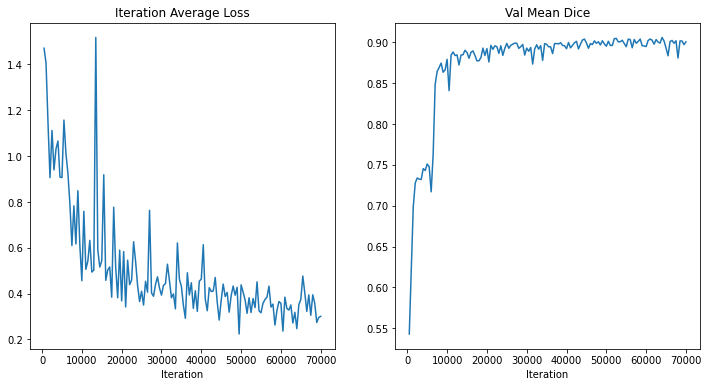

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

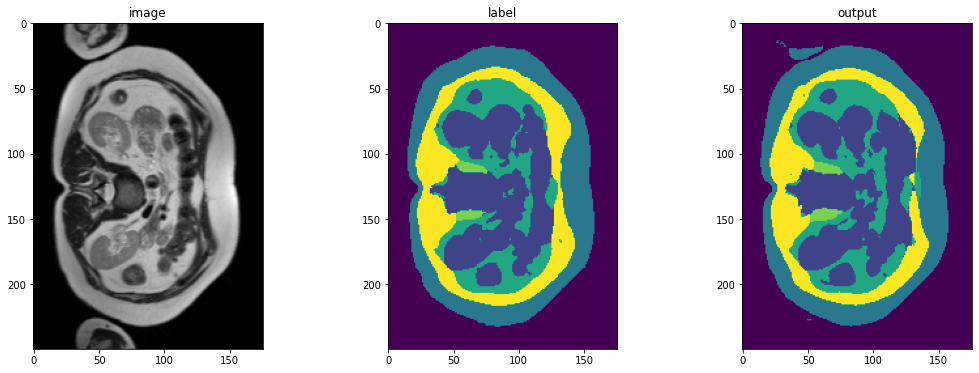

In [12]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR03_May23small.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 48), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
    )
    plt.show()

In [ ]:
val_inputs.shape

### Inference on test images

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [13]:
import glob
from monai.data import Dataset
from monai.handlers.utils import from_engine
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)

test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=200,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=6),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR03_May23small", output_postfix="seg", resample=False, separate_folder=False),
])

In [14]:
print(data_dir)

/home/adminbthomas/Downloads/data/013123_MR/


2023-05-09 06:53:09,517 INFO image_writer.py:194 - writing: outMR03_May23small/A009_v4_T2W_seg.nii.gz


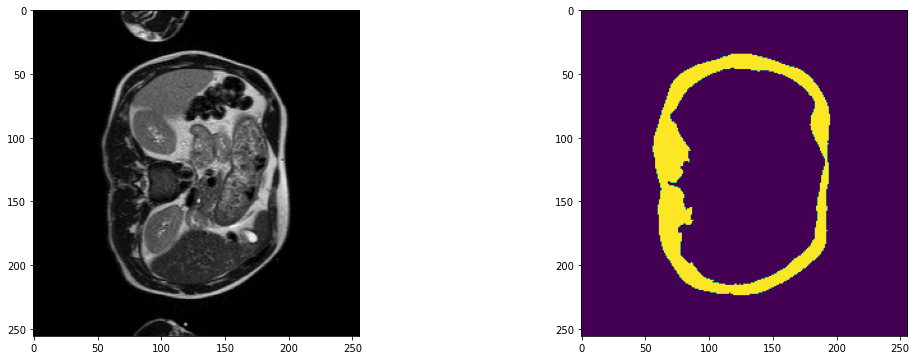

Modifying image pixdim from [1.5625 1.5625 4.     0.    ] to [  1.5625       1.5625       4.         285.79926645]


2023-05-09 06:53:12,320 INFO image_writer.py:194 - writing: outMR03_May23small/A016_v3_T2W_seg.nii.gz


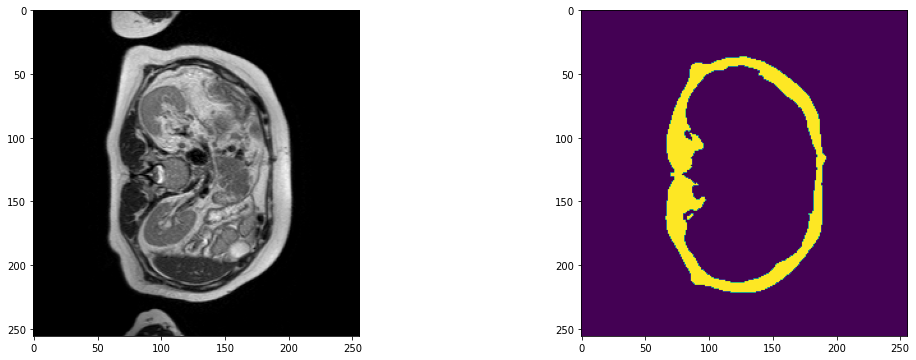

2023-05-09 06:53:15,019 INFO image_writer.py:194 - writing: outMR03_May23small/A028_v5_T2W_seg.nii.gz


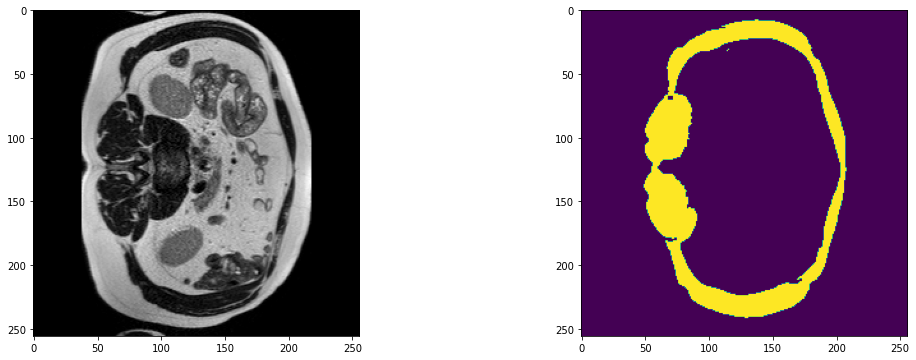

2023-05-09 06:53:23,143 INFO image_writer.py:194 - writing: outMR03_May23small/A034_v5_T2W_seg.nii.gz


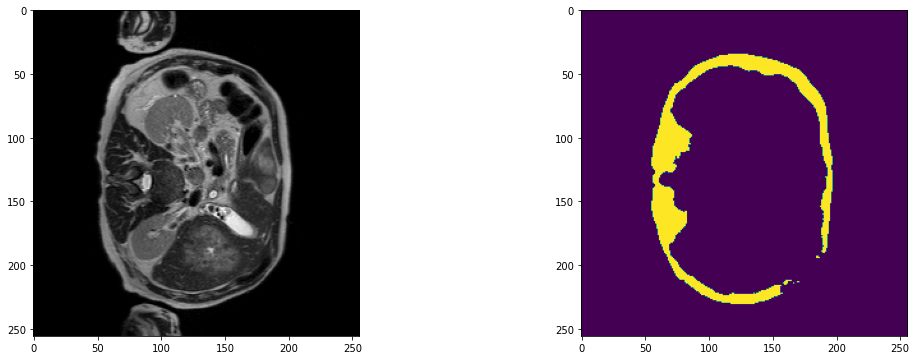

2023-05-09 06:53:31,319 INFO image_writer.py:194 - writing: outMR03_May23small/A061_v5_T2W_seg.nii.gz


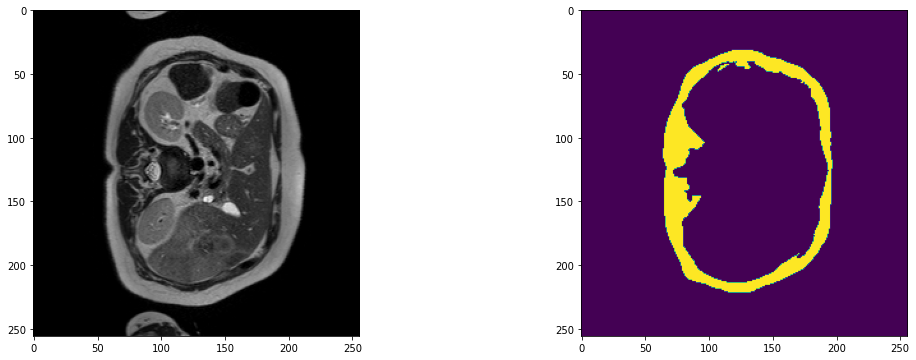

2023-05-09 06:53:34,069 INFO image_writer.py:194 - writing: outMR03_May23small/B002_v1_T2W_seg.nii.gz


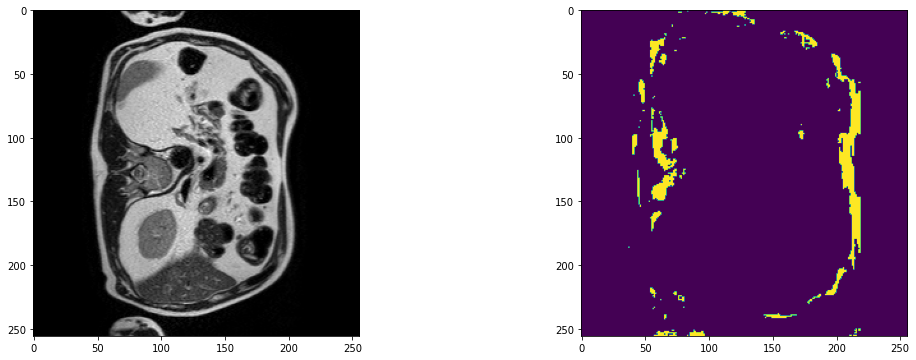

2023-05-09 06:53:36,855 INFO image_writer.py:194 - writing: outMR03_May23small/B003_v2_T2W_seg.nii.gz


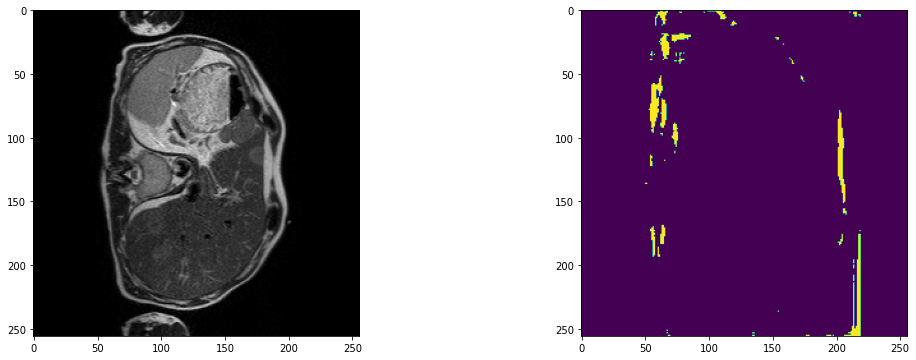

2023-05-09 06:53:45,285 INFO image_writer.py:194 - writing: outMR03_May23small/B004_v3_T2W_seg.nii.gz


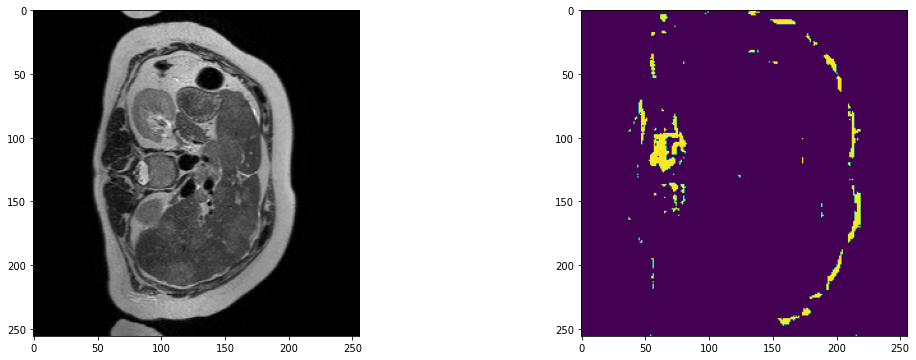

2023-05-09 06:53:48,123 INFO image_writer.py:194 - writing: outMR03_May23small/B005_v4_T2W_seg.nii.gz


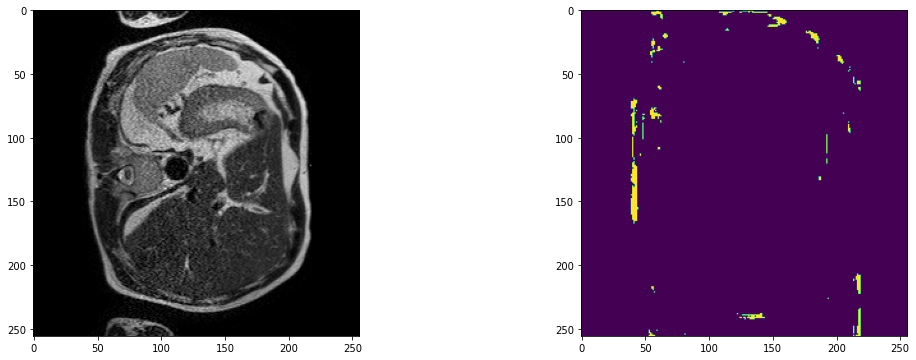

2023-05-09 06:53:50,988 INFO image_writer.py:194 - writing: outMR03_May23small/B006_v5_T2W_seg.nii.gz


Modifying image pixdim from [1.5625 1.5625 4.     0.    ] to [  1.5625       1.5625       4.         285.79926645]


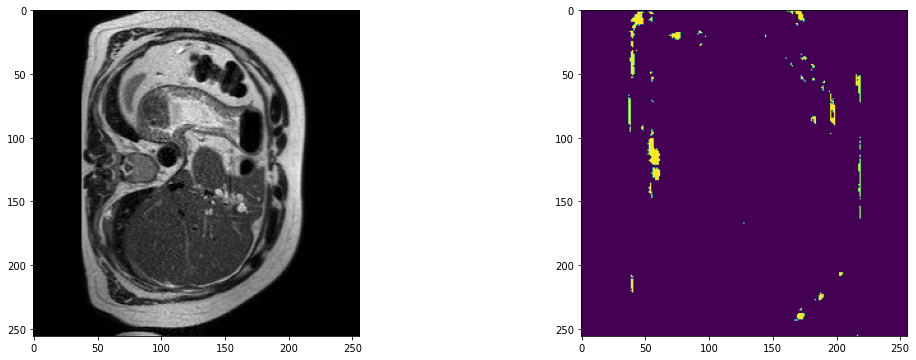

In [15]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR03_May23small.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 48)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 8], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
        plt.show()

In [ ]:
# Testing code modified  (Based on validation block)

from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model_multiclassUNetR_MR03_May23small.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 48)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.8
    )
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 2, 1)
#     plt.title("image")
#     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 40], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("output")
#     plt.imshow(
#         torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 40]
#     )
#     plt.show()      

In [ ]:
plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(
    torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 20]
)
plt.show()

In [ ]:
print(test_output[0].shape)

In [ ]:
slno = 20
plt.figure("check1", (18, 6))
plt.imshow(original_image[:, :, slno], cmap="gray")
plt.figure("check2", (18, 6))
plt.subplot(3, 3, 1)
plt.imshow(test_output[0].detach().cpu()[0, :, :, slno])
plt.subplot(3, 3, 2)
plt.imshow(test_output[0].detach().cpu()[1, :, :, slno])
plt.subplot(3, 3, 3)
plt.imshow(test_output[0].detach().cpu()[2, :, :, slno])
plt.subplot(3, 3, 4)
plt.imshow(test_output[0].detach().cpu()[3, :, :, slno])
plt.subplot(3, 3, 5)
plt.imshow(test_output[0].detach().cpu()[4, :, :, slno])
plt.subplot(3, 3, 6)
plt.imshow(test_output[0].detach().cpu()[5, :, :, slno])
plt.subplot(3, 3, 7)
plt.imshow(test_output[0].detach().cpu()[6, :, :, slno])
plt.subplot(3, 3, 8)
plt.imshow(test_output[0].detach().cpu()[7, :, :, slno])
plt.subplot(3, 3, 9)
plt.imshow(test_output[0].detach().cpu()[8, :, :, slno])
plt.show()